In [1]:
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.gpt2 import GPT2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Definition and training of a simple model

### 1.1. Define tokenizer

In [2]:
# Use pretrained tokenizer
import tiktoken

gpt2_tokenizer = tiktoken.encoding_for_model('gpt-2')
gpt2_tokenizer.n_vocab

### transformers from HuggingFace (slower) ###
# from transformers import GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer
# gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# print(gpt2_tokenizer.vocab_size)

50257

### 1.2. Hyper-parameters of ChatGPT model

In [3]:
# size of the embeddings
n_embd = 300 # 300 # 16
n_head = 6
n_layer = 10 # 10 # 6
block_size = 128 # 256 # 4
batch_size = 16 # 128 # 3
dropout = 0.2
learning_rate= 0.0005 # 3e-4 # 1e-4
eval_interval = 5
max_iters = 2000

### 1.3. Define model variable

In [4]:
m = GPT2(vocab_size=gpt2_tokenizer.n_vocab, block_size=block_size, n_embd=n_embd, n_head=n_head, n_layer=n_layer, dropout=dropout).to(device)

### 1.4. Define how to sample a batch of data for training

In [5]:
def get_batch(source, block_size, batch_size):
    ''' Get batch of size block_size from source'''
    # Generate 'batch_size' random offsets on the data
    # ix = torch.randint(source.shape[1] - block_size, (batch_size,))
    ix = torch.randint(len(source) - block_size, (batch_size,))
    # Collect 'batch_size' subsequences of length 'block_size' 
    # from source, as data and target
    x = torch.stack([source[i:i+block_size] for i in ix])
    # Target is just x shifted right (i.e., the predicted token 
    # is the next in the sequence)
    y = torch.stack([source[i+1:i+1+block_size] for i in ix])
    return x.to(device), y.to(device)

### 1.5. Open a sample text data for training

In [ ]:
with open(os.path.join("sample_data","tiny_shakespeare.txt")) as f:
    text = f.read()
# Use tokenizer to encode text
encoded_text = gpt2_tokenizer.encode(text)

In [ ]:
# Push encoded text to computational tensors
tencoded_text = torch.tensor(encoded_text, dtype=torch.int64).to(device)
# Test get_batch method()
tmp_x, tmp_y = get_batch(tencoded_text, block_size=block_size, batch_size=batch_size)
print(tmp_x.shape, tmp_y.shape)

torch.Size([16, 128]) torch.Size([16, 128])


### 1.6. Training loop

In [ ]:
## Train
losses_list = [] # List to store losses during training
# optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
## Define an optimizer for weights training
optim = torch.optim.AdamW(m.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=3000, eta_min=learning_rate*0.1)
loss_fn = nn.CrossEntropyLoss()

m.train() # Set model to training mode
for ite in tqdm(range(max_iters)):
    # Get a batch every iteration
    input_ids, target_ids = get_batch(tencoded_text, block_size=block_size, batch_size=batch_size)
    # Compute output from model given a batch
    logits = m(input_ids)
    logits = logits.view(batch_size * block_size, gpt2_tokenizer.n_vocab)
    target_ids = target_ids.view(batch_size * block_size)
    # Compute loss using the loss function
    loss = loss_fn(logits, target_ids)  # Compute loss
    # Append to list of losses for later analysis
    losses_list.append(loss.detach().cpu().item())
    # Backward
    loss.backward()
    # gradient clipping
    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1)
    optim.step()
    scheduler.step()
    #  @torch.no_grad()
    # # eval loop: no backprop on this data, to avoid storing all intermediatte variables
    # def eval_loss():
    #     idx, targets = get_batch(valid_data)   #get a batch of validation data
    #     logits = m(idx)   #forward pass
    #     loss = F.cross_entropy(logits, targets)
    #     print(f"step {steps}, eval loss {loss.item():.2f}")
    #     return loss
    
    # if steps % eval_interval == 0: eval_loss().item()
    # if ite % eval_interval == 0:
    #     print(loss.detach().cpu().item())
torch.cuda.empty_cache() # Clean cache memory
# torch.save(m.state_dict(), os.path.join("mygpt2.m")) # Save model to file for later usage

c:\Users\Felix\anaconda3\envs\myproject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2000/2000 [03:39<00:00,  9.09it/s]


### 1.7. Visualize training losses

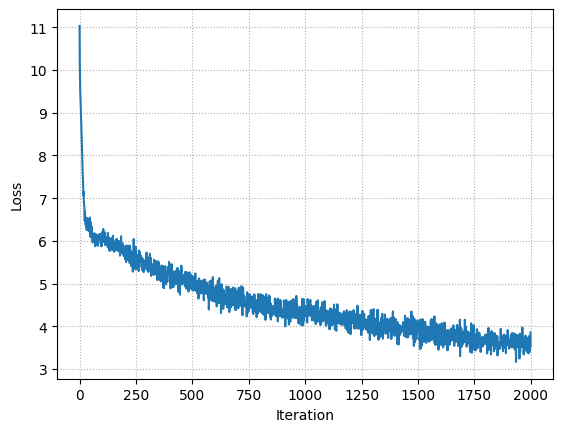

In [9]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(losses_list))], losses_list)
plt.grid(linestyle=":")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [15]:
m = GPT2(vocab_size=gpt2_tokenizer.n_vocab, block_size=block_size, n_embd=n_embd, n_head=n_head, n_layer=n_layer, dropout=dropout).to(device)
m.load_state_dict(torch.load(os.path.join("mygpt2.m"), weights_only=True))
m.eval()

GPT2(
  (token_embedding_table): Embedding(50257, 300)
  (position_embedding_table): Embedding(128, 300)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=300, out_features=50, bias=False)
            (query): Linear(in_features=300, out_features=50, bias=False)
            (value): Linear(in_features=300, out_features=50, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=300, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=300, out_features=1200, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1200, out_features=300, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  

# 2. Prediction

In [ ]:
# Set model to prediction mode
m.eval()
# Define a sample prompt
tmp_prompt = "Hello my friend"
# Encode the prompt text into machine understandable vector
encoded_prompt = gpt2_tokenizer.encode(tmp_prompt)
# Try to decode the prompt to veryfy the tokenizer module
decoded_prompt = gpt2_tokenizer.decode(encoded_prompt)
print("Original message:", tmp_prompt)
print("Decoded prompt:", decoded_prompt)
# Convert encoded prompt to tensor
tmp_input = torch.tensor([encoded_prompt], dtype=torch.int64).to(device)
# Generate text using the model given the prompt
gen_text = m.generate(tmp_input, max_new_tokens=150)
print("gen_text:",gen_text)
# Decode into human understandable text
decoded_text = gpt2_tokenizer.decode(gen_text[0].detach().cpu().tolist())
print("decoded_text:",decoded_text)

Original message: Hello my friend
Decoded prompt: Hello my friend
gen_text: tensor([[15496,   616,  1545,    11,   198,  2514, 44192,   298,   706,   502,
           284, 10597,   314,   481,  7630,  3812,    13,   198,   198,    48,
          8924,  1677, 18805,    38,  1503,  2767,    25,   198,  9590, 33164,
           616,  1021,     0, 11778,    11,   198,  1870,   284, 29702,    11,
           198, 16678,  1302,   502,   326, 43929, 43159,  1365,  2988,   616,
          1751,   287,   262, 33200,    11,   198,  1870, 41276,  4492,    11,
          1577,   683,  1626,   502,  6227,   198,  1870, 10443,   284, 10717,
           326,  9245, 12722,   262,  1573,    13,   198, 23303,    11,  1011,
           674,   898,  2832,    26,   198,  6090, 12703,   736,  1793,    11,
           198,    48,  8924,  1677, 18805,    38,  1503,  2767,    25,   198,
          3666,  2802,    13,   198,   198, 16279,    54, 11860,    25,   198,
            40,   910, 12722,   262,  1182,   318, 1146